In [7]:
import pandas as pd # data analysis/wrangling
import numpy as np # math if required

from scipy import stats # stat tests
from statsmodels.graphics.gofplots import qqplot ## qq plots to assess normality

import matplotlib.pyplot as plt # visuals
import seaborn as sns # visuals


#import libraries
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score


In [2]:
#import data
data = pd.read_csv('/home/sbangarh/AB_cookie_cats/cookie_cats.csv')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
#make copy for manipulations and stuff
copy = data.copy()

#convert userid to str - won't interfre wtih numeric analysis
copy['userid'] = copy['userid'].astype(str)

#change retention_1 and retention_7 to 0/1 boolean
bool_dict = {True: 1, False: 0}
copy[['retention_1', 'retention_7']] = copy[['retention_1', 'retention_7']].map(bool_dict.get)

#check work
copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  object
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.4+ MB


In [4]:
# bots = instances where sum_gamerounds = 0 and one or both retentions are True; 

# make mask to filter bots
my_bots = (copy['sum_gamerounds'] == 0) & ((copy['retention_1'] == 1) | (copy['retention_7'] == 1))

#assign bool based on mask
copy['Bot'] = my_bots.astype(int)

#check work
copy[copy['Bot'] == 1]

,userid,version,sum_gamerounds,retention_1,retention_7,Bot
1000,110479,gate_30,0,0,1,1
1872,203165,gate_30,0,1,0,1
2330,257330,gate_30,0,1,0,1
2803,307703,gate_40,0,1,1,1
3994,442819,gate_30,0,1,0,1
...,...,...,...,...,...,...
86779,9616345,gate_40,0,1,0,1
87635,9708844,gate_30,0,1,0,1
87973,9750017,gate_40,0,1,0,1
88671,9830174,gate_40,0,1,0,1


In [5]:
# Instantiate the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the 'version' column (replace 'copy' with your actual DataFrame)
encoded = encoder.fit_transform(copy[['version']])

# Convert the sparse matrix to a DataFrame (if needed)
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(['version']))

# Display the first few rows
encoded_df.head()

#make new df and concatenate
new_df = copy.copy()

new_df = pd.concat([new_df, encoded_df], axis=1)

#drop columns
new_df = new_df.drop('version', axis=1)

#check
new_df.head()

,userid,sum_gamerounds,retention_1,retention_7,Bot,version_gate_30,version_gate_40
0,116,3,0,0,0,1.0,0.0
1,337,38,1,0,0,1.0,0.0
2,377,165,1,0,0,0.0,1.0
3,483,1,0,0,0,0.0,1.0
4,488,179,1,1,0,0.0,1.0


# Modelling

## Logistic Regression

In [6]:
#declare variables
X = new_df.drop('Bot', axis=1)
y = new_df['Bot']

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y)

#declare pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

In [16]:
#fit model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])

In [18]:
#results
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

#train_report = classification_report(y_train, train_pred)
#test_report = classification_report(y_test, test_pred)

train_balance = balanced_accuracy_score(y_train, train_pred)
test_balance = balanced_accuracy_score(y_test, test_pred)

Balanced Accuracy score: 0.50000


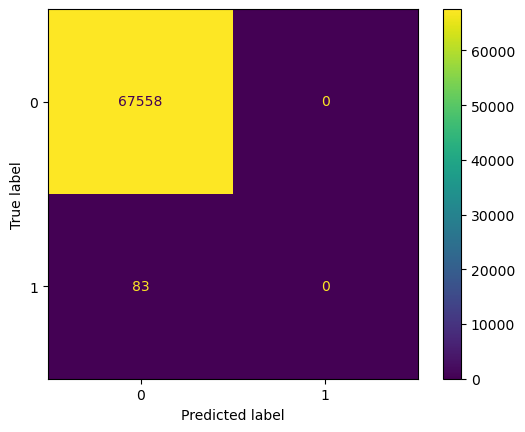

In [24]:
#print train results
#print(train_report)
print(f"Balanced Accuracy score: {train_balance:.5f}")

#plot confusion matrix
matrix = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(matrix)
disp.plot()
plt.show()

Balanced Accuracy score: 0.50000


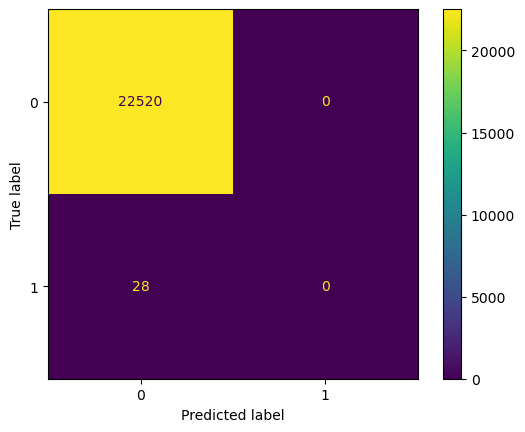

In [23]:
#print test results
#print(test_report)
print(f"Balanced Accuracy score: {test_balance:.5f}")

#plot confusion matrix
matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(matrix)
disp.plot()
plt.show()

## Logistic Regression with log transformed data

I want to see if any difference, Logistic regression, in theory, should be less computationaly expensive than random forest

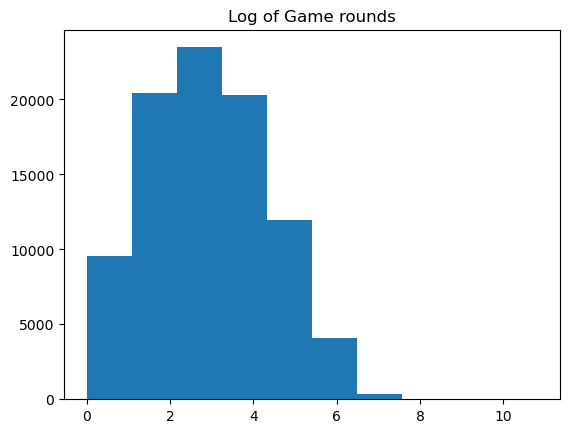

In [17]:
#make copy
log_df = new_df.copy()

#log transform, have to add one to 0's
log_df['sum_gamerounds'] = np.log1p(log_df['sum_gamerounds'])

#plt to see histogram
plt.hist(log_df['sum_gamerounds'])
plt.title('Log of Game rounds')
plt.show()

In [18]:
#declare variables
X = log_df.drop('Bot', axis=1)
y = log_df['Bot']

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y)

#declare pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

In [20]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])

In [21]:
#results
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

#train_report = classification_report(y_train, train_pred)
#test_report = classification_report(y_test, test_pred)

train_balance = balanced_accuracy_score(y_train, train_pred)
test_balance = balanced_accuracy_score(y_test, test_pred)

Balanced Accuracy score: 0.90356


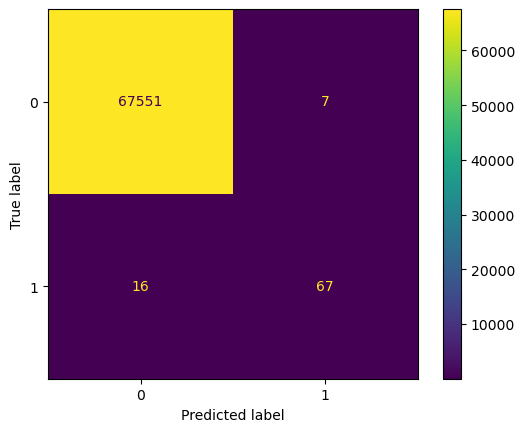

In [22]:
#print train results
#print(train_report)
print(f"Balanced Accuracy score: {train_balance:.5f}")

#plot confusion matrix
matrix = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(matrix)
disp.plot()
plt.show()

Balanced Accuracy score: 0.85712


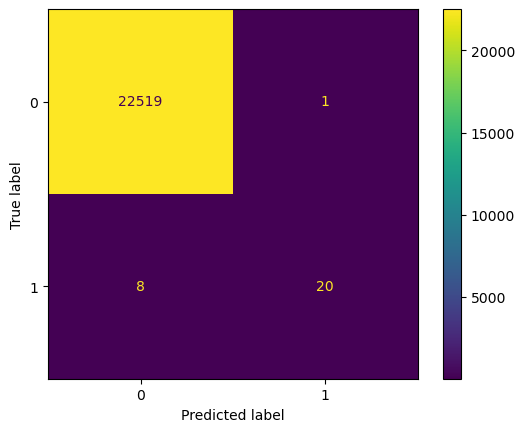

In [23]:
#print test results
#print(test_report)
print(f"Balanced Accuracy score: {test_balance:.5f}")

#plot confusion matrix
matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(matrix)
disp.plot()
plt.show()

A bit better, but the model was over fitting. For now Random Forest will have to do in this case.

## Random forest

In [8]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier())
])

In [9]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

In [10]:
#results
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

#train_report = classification_report(y_train, train_pred)
#test_report = classification_report(y_test, test_pred)

train_balance = balanced_accuracy_score(y_train, train_pred)
test_balance = balanced_accuracy_score(y_test, test_pred)

Balanced Accuracy score: 1.00000


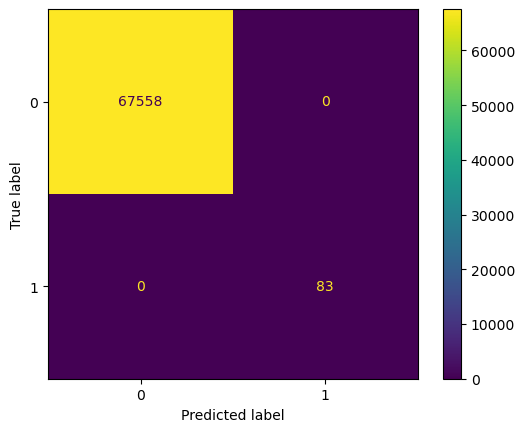

In [11]:
#print train results
#print(train_report)
print(f"Balanced Accuracy score: {train_balance:.5f}")

#plot confusion matrix
matrix = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(matrix)
disp.plot()
plt.show()

Balanced Accuracy score: 1.00000


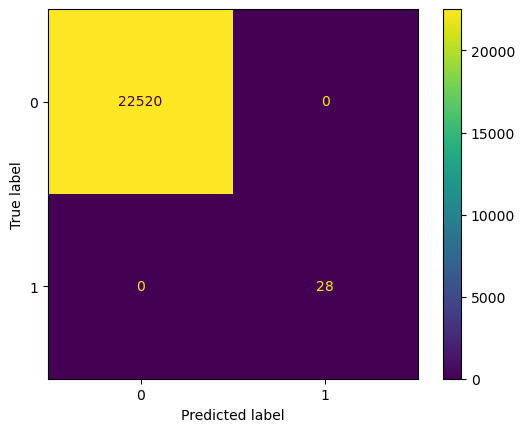

In [15]:
#print test results
#print(test_report)
print(f"Balanced Accuracy score: {test_balance:.5f}")

#plot confusion matrix
matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(matrix)
disp.plot()
plt.show()

# Conclusions

- The linear model did not perform well with a balanced accuracy score of only 0.5. It also struggled to identify the bots correctly on both the training and test data as shown in the confusion matrix.
- RandomForest with its default settings performed much better. Balanced accuracy score of 1 on both train and test data. It was also able to correctly identify bots in both data sets.